In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr

from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
import import_ipynb
import libs

n_steps_in=24*3
n_steps_out=24
n_step=n_steps_in

fnames=pd.read_table('data/names_72.txt',header=None)
fnames=fnames.values[:,0]
fnames= [fn.replace('json','csv') for fn in fnames]

#idx
idx=np.array([ 7,  9,  4,  8, 11,  1, 10,  3,  5,  2,  6, 12])
k=5;idx=idx[:k]

#weather data
data_w=libs.get_weather(idx[idx<11]-1)
#sun data
data_sun=libs.get_sun(idx[idx>=11]-11)
#air data
#data_a=libs.get_air()#10
#y data
data_hr1=[]
for fn in fnames:
    data_hr1.append(pd.read_csv('data/cv_26/'+fn).values[:,0])
data_hr1=np.array(data_hr1)
data_hr1=np.concatenate((data_hr1,np.zeros((47,1))),axis=1)
print(data_hr1.shape,data_w.shape,data_sun.shape)

#faltten
data_hr1=data_hr1.reshape((-1,1))#dataset1.flatten()[:,np.newaxis]#(1128, 1)
clip=24*6
data_hr1=data_hr1[:-clip]
# Feature Scaling
sc1 = MinMaxScaler(feature_range = (0, 1))
data_hr_scaled1 = sc1.fit_transform(data_hr1)
data_hr_scaled1.shape,np.min(data_hr_scaled1),np.max(data_hr_scaled1)

#merge
dataset_scaled1=np.concatenate((data_hr_scaled1,data_w[:-clip],data_sun[:-clip]),axis=-1)
#select
#idx=[0,8,10,5,11,9,1,4,3,6,2,7,12]
#dataset_scaled1=dataset_scaled1[:,idx[:1+1]]

n_features=dataset_scaled1.shape[1]
#train / test split
n_train=len(dataset_scaled1)-24*10
n_test=len(dataset_scaled1)-n_train
training_set_scaled1=dataset_scaled1[:n_train]
test_set_scaled1=dataset_scaled1[n_train:]
print(training_set_scaled1.shape,test_set_scaled1.shape)

plt.rcParams["figure.figsize"] = (20,3)
for i in range(n_features):
    fig=plt.figure()
    fig.add_subplot(1,1,1).plot(dataset_scaled1[:,i])#hr,기온,고도,전운량,시정
plt.show()

Using TensorFlow backend.


importing Jupyter notebook from libs.ipynb


/home/vislab/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(47, 24) (1128, 8) (1128, 1)
(744, 10) (240, 10)


<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

train (552, 72, 10) (552, 24, 10)
test (7, 72, 10) (7, 24, 10)


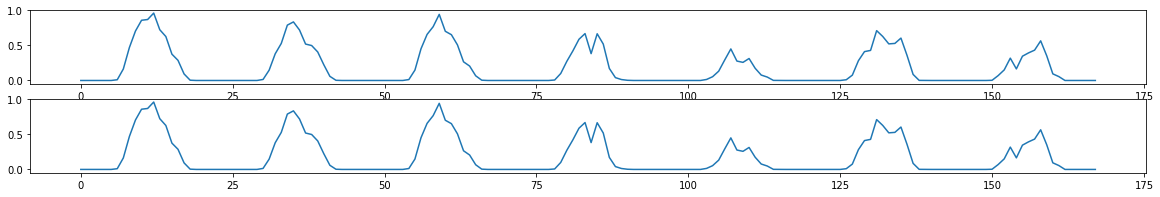

In [3]:
#input/output
X_train = []
y_train = []
for i in range(n_step,22*24-24):
    X_train.append(training_set_scaled1[i-n_step:i])
    y_train.append(training_set_scaled1[i:i+24])
for i in range(22*24+n_step,n_train-24):
    X_train.append(training_set_scaled1[i-n_step:i])
    y_train.append(training_set_scaled1[i:i+24])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], n_features))
print("train",X_train.shape,y_train.shape)#(960, 168, 1),(960,)

X_test = []
y_test=[]
for i in range(n_step, n_test-24+1,24):
    X_test.append(test_set_scaled1[i-n_step:i])
    y_test.append(test_set_scaled1[i:i+24])
X_test,y_test = np.array(X_test),np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], n_features))
print("test",X_test.shape,y_test.shape)

fig=plt.figure()
fig.add_subplot(2,1,1).plot(y_test[:,:,0].flatten())
fig.add_subplot(2,1,2).plot(test_set_scaled1[-y_test.shape[0]*y_test.shape[1]:,0])
plt.show()

## Network

In [4]:
model = Sequential()
#model.add(LSTM(256, activation='relu',dropout=0.5, input_shape=(n_steps_in, n_features)))#9
model.add(LSTM(256,input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(256, activation='relu')))
#model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))

X_train.shape,y_train.shape, np.min(X_train),np.max(X_train),np.min(y_train),np.max(y_train)

((552, 72, 10), (552, 24, 10), 0.0, 1.0, 0.0, 1.0)

model=load_model('model/model8_2.h5')

In [5]:
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_train,y_train[:,:,0:1],batch_size=64,epochs=128,validation_data=(X_test,y_test[:,:,:1]))

Train on 552 samples, validate on 7 samples
Epoch 1/128
552/552 [==============================] - 3s 5ms/step - loss: 0.0596 - val_loss: 0.0691
Epoch 2/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0508 - val_loss: 0.0740
Epoch 3/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0484 - val_loss: 0.0811
Epoch 4/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0489 - val_loss: 0.0718
Epoch 5/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0661
Epoch 6/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0484 - val_loss: 0.0617
Epoch 7/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0438 - val_loss: 0.0722
Epoch 8/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0495 - val_loss: 0.0782
Epoch 9/128
552/552 [==============================] - 1s 2ms/step - loss: 0.3486 - val_loss: 0.0614
Epoch 10/128
552/552 [=========================

Epoch 81/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 82/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0075
Epoch 83/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 84/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0144
Epoch 85/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 86/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0148
Epoch 87/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0147
Epoch 88/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0116
Epoch 89/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 90/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0050

In [7]:
model.save('model/corr_selection/model'+str(k)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

## Result

(168,)


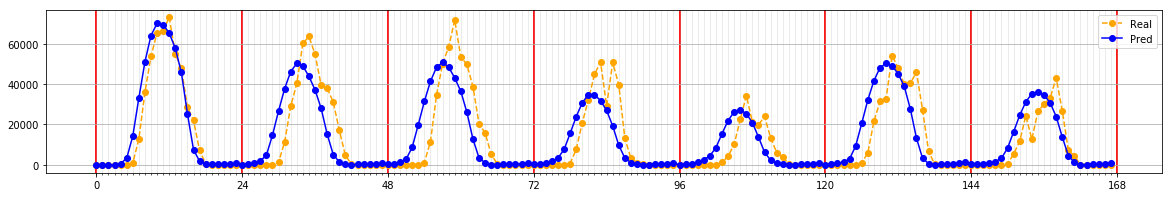

In [6]:
pred1= model.predict(X_test)
pred1=pred1.reshape(-1,1)
pred1 = sc1.inverse_transform(pred1)
pred1=pred1[:,0]
print(pred1.shape)

fig = plt.figure(figsize=(20,3))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

plt.plot(data_hr1[-len(pred1):,0],marker='o',ls='--',c='orange', label = 'Real')
ax.plot(pred1, 'bo-', label = 'Pred') 
ax.legend()

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)                                           
ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='r',axis='x')
plt.savefig('tmp.png')
plt.show()

In [8]:
pred1= model.predict(X_test)
pred1=pred1.reshape(-1,1)
pred1 = sc1.inverse_transform(pred1)
pred1=pred1[:,0]

y_true=sc1.inverse_transform(y_test[:,:,0]).flatten()
y_pred=pred1
rmse=np.sqrt(mean_squared_error(y_true,y_pred))
print('rmse: %.3f'%rmse)
print('rmse/max',rmse/np.max(y_true)*100)
print('rmse/mean',rmse/np.mean(y_true)*100)
print('rmse/std',rmse/np.std(y_true)*100)
print('rmse/IQR',rmse/iqr(y_true)*100)
wape=np.mean(np.abs((y_true -y_pred)/np.mean(y_true))) * 100
print('WAPE: ',wape)

rmse: 10142.955
rmse/max 13.83759151172868
rmse/mean 73.9847329420075
rmse/std 51.20620954712227
rmse/IQR 38.27530029470613
WAPE:  45.82420865695545


In [9]:
pred= model.predict(X_test)
pred=pred[:,:,0]
pred=sc1.inverse_transform(pred)
true=sc1.inverse_transform(y_test[:,:,0])
true.shape,pred.shape

rmse=[]
nrmse_max=[]
nrmse_mean=[]
nrmse_std=[]
nrmse_iqr=[]
wape=[]
for i in range(len(pred)):
    r=np.sqrt(mean_squared_error(true[i],pred[i]))
    rmse.append(r)
    nrmse_max.append(r/np.max(true[i]))
    nrmse_mean.append(r/np.mean(true[i]))
    nrmse_std.append(r/np.std(true[i]))
    nrmse_iqr.append(r/iqr(true[i]))
    wape.append(np.mean(np.abs((true[i] -pred[i])/np.mean(true[i]))))
error_dic=[nrmse_max,nrmse_mean,nrmse_std,nrmse_iqr,wape]
rmse

[12555.933871427773,
 11235.44745938997,
 12374.52872869958,
 8936.867190999183,
 7029.590729718318,
 11322.341730247232,
 5065.847755924146]

In [10]:
for i in range(5):
    print(sum(error_dic[i])/len(error_dic[i]))

0.17519952515406625
0.7356724162108463
0.5326690153963095
0.3903575594535936
0.4672499194507759


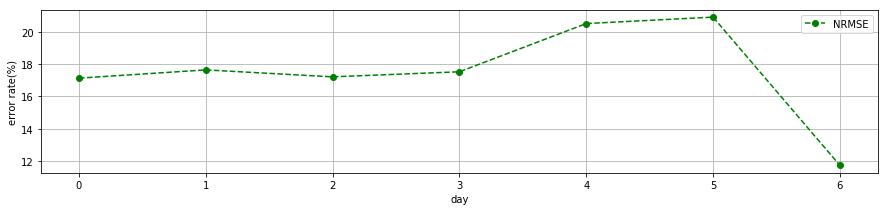

In [11]:
plt.figure(figsize=(15,3))
plt.plot(np.array(nrmse_max)*100,'go--',label='NRMSE')
#plt.plot([40 for i in range(len(pred))],'r',label='40% axis')
plt.xlabel('day')
plt.ylabel('error rate(%)')
plt.legend()
plt.grid()
plt.show()

/home/vislab/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


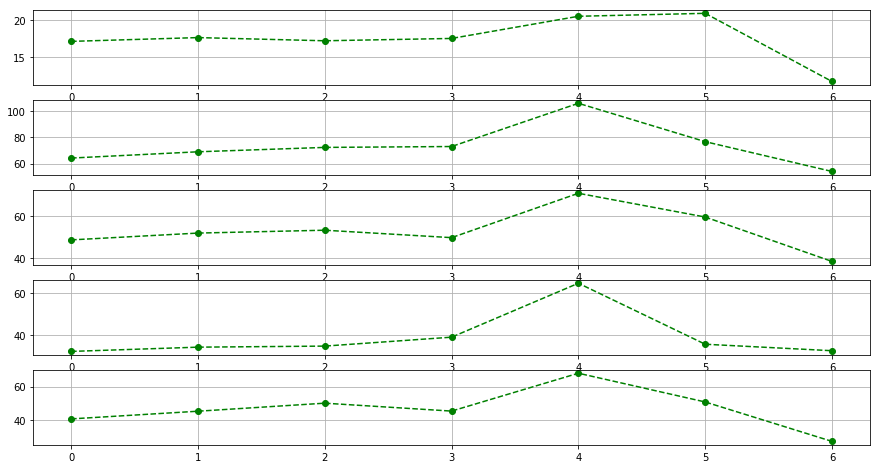

In [12]:
fig=plt.figure(figsize=(15,8))

for i in range(5):
    fig.add_subplot(5,1,i+1).plot(np.array(error_dic[i])*100,'go--')
    fig.add_subplot(5,1,i+1).grid()
plt.show()